In [1]:
import numpy as np
import pandas as pd 
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score,roc_curve
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier  

In [2]:
data = pd.read_csv("hmelq.csv")
data.head()

,bad,loan,mortdue,value,reason,job,yoj,derog,delinq,clage,ninq,clno,debtinc
0,0,81200,18834.0,108355.0,HomeImp,NaN,28.0,0.0,0.0,139.14,0.0,14.0,34.042
1,0,12600,103960.0,127384.0,DebtCon,NaN,2.0,0.0,0.0,129.02,0.0,25.0,34.479
2,0,18000,46865.0,61266.0,DebtCon,NaN,5.0,0.0,0.0,102.59,2.0,9.0,26.354
3,0,10300,57676.0,71027.0,DebtCon,NaN,19.0,0.0,0.0,157.52,1.0,11.0,33.992
4,0,9400,56508.0,78358.0,DebtCon,NaN,17.0,0.0,0.0,141.93,0.0,11.0,32.327


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3576 entries, 0 to 3575
Data columns (total 13 columns):
bad        3576 non-null int64
loan       3576 non-null int64
mortdue    3262 non-null float64
value      3512 non-null float64
reason     3429 non-null object
job        3409 non-null object
yoj        3264 non-null float64
derog      3149 non-null float64
delinq     3225 non-null float64
clage      3397 non-null float64
ninq       3273 non-null float64
clno       3443 non-null float64
debtinc    2809 non-null float64
dtypes: float64(9), int64(2), object(2)
memory usage: 363.3+ KB


In [4]:
data.dropna(inplace=True)
data.describe()

,bad,loan,mortdue,value,yoj,derog,delinq,clage,ninq,clno,debtinc
count,2018.000000,2018.000000,2018.000000,2018.000000,2018.000000,2018.000000,2018.000000,2018.000000,2018.000000,2018.000000,2018.000000
mean,0.088206,19010.257681,76337.035183,106899.244797,9.003964,0.150149,0.264123,180.645020,1.037661,22.265114,34.105829
std,0.283665,10768.607345,44476.368189,54026.707096,7.573012,0.580421,0.789816,84.420116,1.578414,9.457238,8.438411
min,0.000000,1700.000000,5076.000000,23031.000000,0.000000,0.000000,0.000000,0.490000,0.000000,0.000000,4.030000
25%,0.000000,12000.000000,49577.250000,71287.250000,3.000000,0.000000,0.000000,118.205000,0.000000,16.000000,29.295500
50%,0.000000,16900.000000,67595.000000,94514.000000,7.000000,0.000000,0.000000,176.670000,0.000000,21.000000,34.949000
75%,0.000000,23600.000000,92922.750000,121220.750000,13.000000,0.000000,0.000000,229.692500,2.000000,27.000000,38.952000
max,1.000000,89900.000000,399412.000000,512650.000000,41.000000,10.000000,10.000000,1168.230000,13.000000,64.000000,144.189000


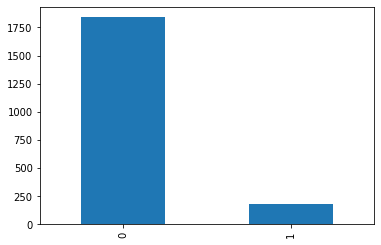

In [5]:
# counting the values of bad column
data['bad'].value_counts().plot.bar()

In [6]:
# creating dummy columns for categorical variables
dms = pd.get_dummies(data[['reason', 'job']])
dms.head()

,reason_DebtCon,reason_HomeImp,job_Mgr,job_Office,job_Other,job_ProfEx,job_Sales,job_Self
153,1,0,1,0,0,0,0,0
154,1,0,1,0,0,0,0,0
155,1,0,1,0,0,0,0,0
156,0,1,1,0,0,0,0,0
157,1,0,1,0,0,0,0,0


In [7]:
# dropping the categoricals and adding the dummies
X_ = data.drop(['bad', 'reason', 'job'],axis=1)
X = pd.concat([X_, dms[["reason_DebtCon", "job_Mgr","job_Office","job_ProfEx","job_Sales","job_Self"]]], axis = 1)

In [8]:
# splitting the data as train and test
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
y = data["bad"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1614, 16), (1614,), (404, 16), (404,))

In [9]:
X_train.head()

,loan,mortdue,value,yoj,derog,delinq,clage,ninq,clno,debtinc,reason_DebtCon,job_Mgr,job_Office,job_ProfEx,job_Sales,job_Self
1181,23400,72262.0,94646.0,2.0,0.0,0.0,106.00,1.0,29.0,31.841,1,0,0,0,0,0
2220,4800,80482.0,88342.0,7.0,0.0,0.0,275.03,0.0,11.0,43.718,0,0,0,1,0,0
397,21300,133942.0,282972.0,3.0,0.0,0.0,197.15,0.0,15.0,30.545,0,1,0,0,0,0
2490,21700,187311.0,230513.0,2.0,0.0,0.0,270.48,0.0,27.0,38.999,1,0,0,1,0,0
2302,24200,91491.0,141827.0,21.0,1.0,0.0,163.17,0.0,25.0,42.061,1,0,0,1,0,0


In [10]:
# stats models logistic regression with all variables
loj = sm.Logit(y, X)
loj_model = loj.fit()
loj_model.summary()

Optimization terminated successfully.
         Current function value: 0.255671
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    bad   No. Observations:                 2018
Model:                          Logit   Df Residuals:                     2002
Method:                           MLE   Df Model:                           15
Date:                Fri, 20 Sep 2019   Pseudo R-squ.:                  0.1431
Time:                        22:35:29   Log-Likelihood:                -515.94
converged:                       True   LL-Null:                       -602.11
Covariance Type:            nonrobust   LLR p-value:                 8.341e-29
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
loan           -1.932e-05   1.04e-05     -1.861      0.063   -3.97e-05    1.02e-06
mortdue        -1.385e-06   4.94e-06     -0.280      0.779   -1.11e-05     8.3e-06
value          -2.308e-06   4.18e-06     -0.553      0.580   -1.05e-05    5.88e-06
yoj               -0.0345      0.013     -2.698      0.007      -0.060      -0.009
derog              0.5416      0.126      4.314      0.000       0.296       0.788
delinq             0.7600      0.088      8.605      0.000       0.587       0.933
clage             -0.0083      0.001     -6.264      0.000      -0.011      -0.006
ninq               0.0580      0.048      1.212      0.226      -0.036       0.152
clno              -0.0413      0.011     -3.822      0.000      -0.062      -0.020
debtinc            0.0235      0.007      3.303      0.001       0.010       0.037
reason_DebtCon    -0.4757      0.177     -2.690      0.007      -0.822      -0.129
job_Mgr           -0.0941      0.256     -0.367      0.714      -0.597       0.409
job_Office        -0.6638      0.270     -2.459      0.014      -1.193      -0.135
job_ProfEx        -0.2196      0.242     -0.907      0.364      -0.694       0.255
job_Sales          1.0547      0.556      1.898      0.058      -0.035       2.144
job_Self           0.9778      0.518      1.887      0.059      -0.038       1.993
==================================================================================
"""

In [11]:
X = X.drop(['mortdue','value','ninq','job_Mgr','job_ProfEx','job_Self'], axis = 1)


In [12]:
# stats models logistic regression with useful columns
loj = sm.Logit(y, X)
loj_model = loj.fit()
loj_model.summary()

Optimization terminated successfully.
         Current function value: 0.257809
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    bad   No. Observations:                 2018
Model:                          Logit   Df Residuals:                     2008
Method:                           MLE   Df Model:                            9
Date:                Fri, 20 Sep 2019   Pseudo R-squ.:                  0.1359
Time:                        22:35:29   Log-Likelihood:                -520.26
converged:                       True   LL-Null:                       -602.11
Covariance Type:            nonrobust   LLR p-value:                 1.266e-30
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
loan           -2.235e-05   9.72e-06     -2.300      0.021   -4.14e-05    -3.3e-06
yoj               -0.0354      0.013     -2.800      0.005      -0.060      -0.011
derog              0.5842      0.126      4.652      0.000       0.338       0.830
delinq             0.7730      0.088      8.805      0.000       0.601       0.945
clage             -0.0089      0.001     -6.981      0.000      -0.011      -0.006
clno              -0.0485      0.010     -4.815      0.000      -0.068      -0.029
debtinc            0.0224      0.006      3.473      0.001       0.010       0.035
reason_DebtCon    -0.4380      0.171     -2.567      0.010      -0.772      -0.104
job_Office        -0.6288      0.256     -2.458      0.014      -1.130      -0.127
job_Sales          1.1141      0.545      2.042      0.041       0.045       2.183
==================================================================================
"""

In [13]:
# sklearn logistic regression
from sklearn.linear_model import LogisticRegression
loj = LogisticRegression(solver = 'liblinear')
loj_model = loj.fit(X,y)
loj_model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [14]:
loj_model.intercept_, loj_model.coef_

(array([-1.45335355]),
 array([[-1.79348348e-05, -2.79320200e-02,  6.03222658e-01,
          7.09407839e-01, -6.99935728e-03, -3.90743758e-02,
          4.51533687e-02, -3.79526020e-01, -5.08152845e-01,
          2.06924171e-01]]))

In [18]:
# confusion matrix and accuracy
y_pred = loj_model.predict(X)
confusion_mat = confusion_matrix(y, y_pred)
accuracy = accuracy_score(y, y_pred)
print("Counfusion matrix: \n",confusion_mat)
print("Accuracy: ",accuracy)
# model's accuracy looks good

Counfusion matrix: 
 [[1833    7]
 [ 146   32]]
Accuracy:  0.9241823587710605


In [16]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1840
           1       0.82      0.18      0.29       178

    accuracy                           0.92      2018
   macro avg       0.87      0.59      0.63      2018
weighted avg       0.92      0.92      0.90      2018



fpr:  [0.         0.         0.         0.00054348 0.00054348 0.00108696
 0.00108696 0.00163043 0.00163043 0.00217391]
tpr:  [0.         0.00561798 0.08426966 0.08426966 0.10674157 0.10674157
 0.11797753 0.11797753 0.12921348 0.12921348]
thresholds:  [1.99349083 0.99349083 0.83764986 0.80096946 0.74234162 0.73083897
 0.71849343 0.68264527 0.67259843 0.66098512]


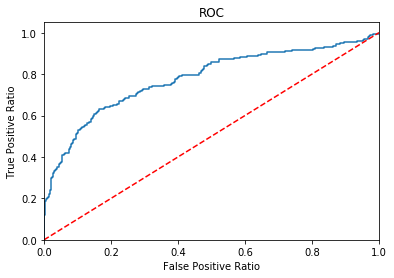

In [19]:
logit_roc_auc = roc_auc_score(y, loj_model.predict(X))
fpr, tpr, thresholds = roc_curve(y, loj_model.predict_proba(X)[:,1])
print("fpr: ",fpr[0:10])
print("tpr: ",tpr[0:10])
print("thresholds: ",thresholds[0:10])
plt.figure()
plt.plot(fpr, tpr, label = 'AUC (area = %0.2f)' % logit_roc_auc)
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Ratio')
plt.ylabel('True Positive Ratio')
plt.title('ROC')
plt.show()